In [1]:
import pandas as pd
from typing import List
import numpy as np

# Unique values above/below a threshold

In [2]:
def get_freq(df, cols:List[str], threshold:int):
    
    # Count the frequency of unique strings
    df_freq = df[cols].stack().value_counts()
    
    # Number of unique strings with a count above the threshold
    above_threshold = df_freq[df_freq >= threshold].shape[0]
    
    # Number of unique strings with a count below the threshold
    below_threshold = df_freq[df_freq < threshold].shape[0]
    
    # Percentage of all values that are None
    none_percentage = df[cols].isnull().mean().mean() * 100
    none_percentage = round(none_percentage, 2)
    
    if "reactant_000" in cols or "product_000" in cols:
        return df_freq.shape[0], 0, none_percentage
    else:
        return above_threshold, below_threshold, none_percentage

    


In [3]:
def build_overleaf_table(path, list_of_cols, threshold):
    df = pd.read_parquet(path)
    for cols in list_of_cols:
        above_threshold, below_threshold, none_percentage = get_freq(df, cols, threshold)
        if len(cols) > 4:
            component = "everything"
        else:
            component, _ = cols[0].split("_")
        
    
        table_entry = f"""
        {component} & {above_threshold} // {below_threshold} // {none_percentage} & 
        """
        print(table_entry)
    
    
    

In [4]:
solv_cols = ["solvent_000", "solvent_001"]
catalyst_cols = ["catalyst_000"]
agent_cols = ["agent_000", "agent_001", "agent_002"]
reagent_cols = ["reagent_000", "reagent_001"]
reactant_cols = ["reactant_000", "reactant_001"]
product_cols = ["product_000"]

In [5]:
path = "/Users/dsw46/Projects_local/orderly_07_06/ORDerly/data/orderly/uspto_no_trust/filtered/filtered_orderly_ord.parquet"
threshold = 100
list_of_cols = [reactant_cols, product_cols, solv_cols, agent_cols]
build_overleaf_table(path, list_of_cols, threshold)


        reactant & 317184 // 0 // 18.35 & 
        

        product & 382850 // 0 // 0.0 & 
        

        solvent & 85 // 313 // 28.02 & 
        

        agent & 255 // 11945 // 37.04 & 
        


In [6]:
path = "/Users/dsw46/Projects_local/orderly_07_06/ORDerly/data/orderly/uspto_with_trust/filtered/filtered_orderly_ord.parquet"
threshold = 100
list_of_cols = [reactant_cols, product_cols, solv_cols, catalyst_cols+reagent_cols]
build_overleaf_table(path, list_of_cols, threshold)


        reactant & 40020 // 0 // 25.7 & 
        

        product & 38816 // 0 // 0.0 & 
        

        solvent & 29 // 204 // 40.88 & 
        

        catalyst & 48 // 447 // 56.18 & 
        


In [4]:
path = "/Users/dsw46/Projects_local/orderly_07_06/ORDerly/data/orderly/uspto_no_trust/filtered/filtered_orderly_ord.parquet"
df = pd.read_parquet(path)
df.shape

(411538, 17)

In [2]:
import pandas as pd

In [6]:
df['product_000'].value_counts().shape

(382850,)

# Distance distributions - reaction

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns

from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem, DataStructs

In [7]:
def distance_distribution(input_path, n, output_path='jaccard_distance_distribution.npy'):
    # Step 1: Read in the path as a df with pandas
    df = pd.read_parquet(input_path)
    
    # Step 2: Sample n rows from the df
    sampled_df = df.sample(n)
    
    # Step 3: Create prod_cols and react_cols
    prod_cols = [col for col in sampled_df.columns if 'product' in col]
    react_cols = [col for col in sampled_df.columns if 'reactant' in col]
    
    # Step 4: Calculate count fingerprints for reactants and products
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    reaction_fps = []
    for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc='Creating fingerprints'):
        reactants = [row[col] for col in react_cols if row[col] is not None]
        products = [row[col] for col in prod_cols if row[col] is not None]

        reactant_str = '.'.join(reactants)
        product_str = '.'.join(products)

        r_mol = Chem.MolFromSmiles(reactant_str)
        p_mol = Chem.MolFromSmiles(product_str)
        r_fp = mfpgen.GetCountFingerprint(r_mol)
        p_fp = mfpgen.GetCountFingerprint(p_mol)
        r_array = np.zeros((0,), dtype=np.int8)
        p_array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(r_fp, r_array)
        DataStructs.ConvertToNumpyArray(p_fp, p_array)
        reaction_fp = p_array - r_array
        
        if np.linalg.norm(reaction_fp) == 0:
            print('Zero vector found: ', reactant_str, ' -> ', product_str)
        
        reaction_fps += [reaction_fp]
    
    # Step 5: Calculate pairwise similarities and update histogram bins
    bins = np.arange(-1.01, 1.01, 0.01)
    hist = np.zeros(len(bins) - 1)
    
    def cosine_similarity(vec1, vec2):
        vec1_norm = np.linalg.norm(vec1)
        vec2_norm = np.linalg.norm(vec2)
        if vec1_norm == 0 or vec2_norm == 0:
            return 0
        return np.dot(vec1, vec2) / (vec1_norm * vec2_norm)
    
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            # similarity = DataStructs.TanimotoSimilarity(reaction_fps[i], reaction_fps[j])
            
            dist = cosine_similarity(reaction_fps[i], reaction_fps[j])
            bin_index = int((dist -0.000001 + 1.01) / 0.01)  # Calculate the bin index #subtract a bit to ensure we don't hit 1.0 when dist is 1.0
            hist[bin_index] += 1
            

    
    
    # Step 7: Save the Jaccard distance distribution
    np.save(output_path, hist)
    
    # # Optionally, you can plot the distribution
    # plt.bar(bins[:-1], hist, width=0.01)
    # plt.xlabel('Jaccard Distance')
    # plt.ylabel('Frequency')
    # plt.title('Jaccard Distance Distribution')
    # plt.savefig('jaccard_distance_distribution.png')
    # plt.show()
    
    # hist, _ = np.histogram(jaccard_distances, bins=bins)


In [8]:
# Call the function with your desired path and n
n = 100
# orderly benchmark
distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_orderly_benchmark.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_orderly_benchmark.npy')

100%|██████████| 100/100 [00:00<00:00, 1322.87it/s]


In [9]:
n=100
#mid
distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_mid_filtering.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_mid_filtering.npy')


100%|██████████| 100/100 [00:00<00:00, 1369.75it/s]


In [10]:
n=100
#loose
distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_loose_filtering.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_loose_filtering.npy')

100%|██████████| 100/100 [00:00<00:00, 1355.89it/s]


In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem

def plot_jaccard_distance_line_graph(path1, path2, path3, save_path=None):
    # Load the Jaccard distance distributions from the provided paths
    hist1 = np.load(path1)
    hist2 = np.load(path2)
    hist3 = np.load(path3)
    
    hist1= hist1
    hist2= hist2
    hist3= hist3
    
    # Ensure the histograms have the same number of bins
    assert hist1.shape == hist2.shape == hist3.shape, "Histogram shapes must match"
    
    bins = np.arange(-1.01, 1.01, 0.01)
    
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot the line graphs using Seaborn
    sns.set(style="white")
    plt.figure(figsize=(10, 6))
    
    # Plot line graphs
    sns.lineplot(x=bin_centers, y=hist1, color='blue', label='Histogram 1')
    sns.lineplot(x=bin_centers, y=hist2, color='orange', label='Histogram 2')
    sns.lineplot(x=bin_centers, y=hist3, color='green', label='Histogram 3')
    
    # Shade the area under the lines with the same color as the lines
    plt.fill_between(bin_centers, hist1, color='blue', alpha=0.2)
    plt.fill_between(bin_centers, hist2, color='orange', alpha=0.2)
    plt.fill_between(bin_centers, hist3, color='green', alpha=0.2)
    
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Density')
    plt.title('Cosine Similarity Distribution')
    plt.legend()
    
    # Save the plot if a save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    # Display the plot
    plt.show()



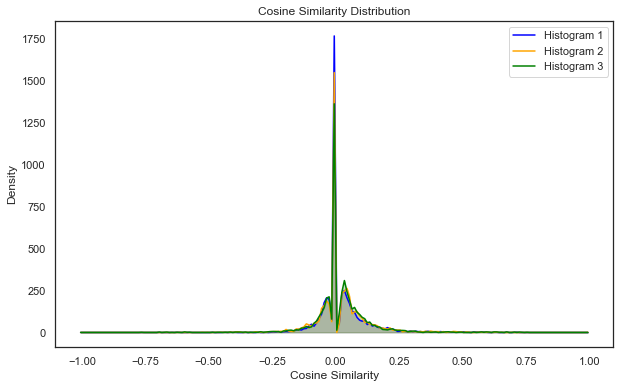

In [12]:

# Call the function with the paths to the Jaccard distance distribution files
path1 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_orderly_benchmark.npy'
path2 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_mid_filtering.npy'
path3 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_loose_filtering.npy'
save_path = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_jaccard_distance.png'
plot_jaccard_distance_line_graph(path1, path2, path3, save_path)

In [18]:
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
mol = Chem.MolFromSmiles("CCCCCCCCO")
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
fp = mfpgen.GetCountFingerprint(mol)
array = np.zeros((0,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(fp, array)

In [19]:
sum(array)

25

# Distribution of tanimoto: products

In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
from scipy.spatial import distance

In [2]:
def jaccard_distance_distribution(input_path, n, output_path='jaccard_distance_distribution.npy'):
    # Step 1: Read in the path as a df with pandas
    df = pd.read_parquet(input_path)
    
    # Step 2: Sample n rows from the df
    sampled_df = df.sample(n)
    
    # Step 3: Create prod_cols and react_cols
    prod_cols = [col for col in sampled_df.columns if 'product' in col]
    ag_cols = [col for col in sampled_df.columns if 'agent' in col]
    
    # Step 4: Calculate count fingerprints for reactants and products
    fps = []
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df), desc='Creating fingerprints'):
        ags = [row[col] for col in ag_cols if row[col] is not None]
        products = [row[col] for col in prod_cols if row[col] is not None]

        agent_str = '.'.join(ags)
        product_str = '.'.join(products)
        
        # Convert SMILES string to RDKit molecule object
        mol = Chem.MolFromSmiles(agent_str)

        # Calculate the Morgan fingerprint
        radius = 2  # Specify the fingerprint radius
        nBits = 2048  # Specify the number of bits (length of fingerprint)
        fp = mfpgen.GetCountFingerprint(mol)
        array = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        
        fps += [array]
    
        
    # Step 5: Calculate pairwise similarities and update histogram bins
    # bins = np.arange(0, 1.01, 0.01)
    # hist = np.zeros(len(bins)-1)
    hist =[]
    
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            # jaccard_distance = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            # jaccard_distance = distance.jaccard(fps[i], fps[j])
            dist = np.linalg.norm(fps[i] - fps[j])
            hist += [dist]
            # bin_index = int((jaccard_distance - 0.000001) / 0.01) # need to subtract a bit in case there's similarity of 1.0
            # hist[bin_index] += 1
            
            

    
    
    # Step 7: Save the Jaccard distance distribution
    np.save(output_path, hist)
    
    # # Optionally, you can plot the distribution
    # plt.bar(bins[:-1], hist, width=0.01)
    # plt.xlabel('Jaccard Distance')
    # plt.ylabel('Frequency')
    # plt.title('Jaccard Distance Distribution')
    # plt.savefig('jaccard_distance_distribution.png')
    # plt.show()
    
    # hist, _ = np.histogram(jaccard_distances, bins=bins)


In [4]:
# Call the function with your desired path and n
n = 1000
# orderly benchmark
reaction_fp = jaccard_distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_orderly_benchmark.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_orderly_benchmark.npy')

Creating fingerprints:   0%|          | 0/1000 [00:00<?, ?it/s][17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not removing hydrogen atom without neighbors
[17:32:21] WARNING: not rem

In [5]:
n=1000
#mid
jaccard_distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_mid_filtering.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_mid_filtering.npy')


Creating fingerprints:   0%|          | 0/1000 [00:00<?, ?it/s][17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not removing hydrogen atom without neighbors
[17:32:27] WARNING: not rem

In [6]:
n=1000
#loose
jaccard_distance_distribution('/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_generated_datasets/forward_loose_filtering.parquet', n, '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_loose_filtering.npy')

Creating fingerprints:   0%|          | 0/1000 [00:00<?, ?it/s][17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
[17:32:35] WARNING: not removing hydrogen atom without neighbors
Creating fingerprints:  42%

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem

def plot_jaccard_distance_line_graph(path1, path2, path3, save_path=None):
    # Load the Jaccard distance distributions from the provided paths
    hist1 = np.load(path1)
    hist2 = np.load(path2)
    hist3 = np.load(path3)
    
    hist1= hist1/np.sum(hist1)
    hist2= hist2/np.sum(hist2)
    hist3= hist3/np.sum(hist3)
    
    # Ensure the histograms have the same number of bins
    assert hist1.shape == hist2.shape == hist3.shape, "Histogram shapes must match"
    
    bins = np.arange(0, 1.01, 0.01)
    
    # Calculate bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot the line graphs using Seaborn
    sns.set(style="white")
    plt.figure(figsize=(10, 6))
    
    # Plot line graphs
    sns.histplot(hist1, color='blue', label='Histogram 1', element="poly")
    sns.histplot(hist2, color='orange', label='Histogram 2', element="poly")
    sns.histplot(hist3, color='green', label='Histogram 3', element="poly")
    
    # sns.lineplot(x=bin_centers, y=hist1, color='blue', label='Histogram 1')
    # sns.lineplot(x=bin_centers, y=hist2, color='orange', label='Histogram 2')
    # sns.lineplot(x=bin_centers, y=hist3, color='green', label='Histogram 3')
    
    # # Shade the area under the lines with the same color as the lines
    # plt.fill_between(bin_centers, hist1, color='blue', alpha=0.2)
    # plt.fill_between(bin_centers, hist2, color='orange', alpha=0.2)
    # plt.fill_between(bin_centers, hist3, color='green', alpha=0.2)
    
    plt.xlabel('Euclidian Distance (agents)')
    plt.ylabel('Density')
    plt.title('Euclidian Distance Distribution')
    plt.legend()
    
    # Save the plot if a save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    
    # Display the plot
    plt.show()



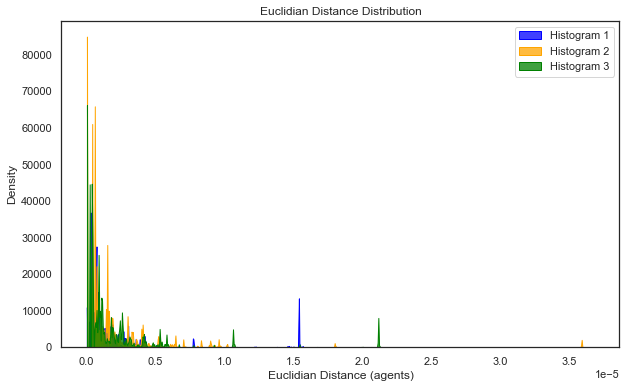

In [8]:

# Call the function with the paths to the Jaccard distance distribution files
path1 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_orderly_benchmark.npy'
path2 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_mid_filtering.npy'
path3 = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_loose_filtering.npy'
save_path = '/Users/dsw46/Projects_local/orderly_reviewer_response/orderly_tanimoto_dist/forward_jaccard_distance.png'
plot_jaccard_distance_line_graph(path1, path2, path3, save_path)